In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from nltk.corpus import stopwords
import nltk
import string
from itertools import combinations, product
from scipy.special import softmax
from sklearn import preprocessing
import seaborn as sns; sns.set_theme()
import glob

import matplotlib.pyplot as plt

# 1 Data Clean
Overview

In [2]:
file_name = '../data/TRNA_V4.news.2006.csv'
news_2006 = pd.read_csv(file_name, sep = ",", header = 0, index_col = ['sourceTimestamp'], engine='c') 	
news_2006.columns

Index(['Unnamed: 0', 'amerTimestamp', 'apacTimestamp', 'emeaTimestamp', 'id',
       'dataType', 'feedFamilyCode', 'headline', 'language', 'altId',
       'feedTimestamp', 'isArchive', 'audiences', 'firstCreated',
       'instancesOf', 'takeSequence', 'provider', 'sourceId', 'subjects',
       'urgency', 'bodySize', 'companyCount', 'exchangeAction', 'headlineTag',
       'marketCommentary', 'sentenceCount', 'wordCount', 'systemVersion'],
      dtype='object')

In [3]:
news_2006.shape

(1708641, 28)

In [4]:
# target news ticker columns
subset = ['subjects']
news_tickers = news_2006[subset]
news_tickers.head()

,subjects
sourceTimestamp,
2005-12-31 21:00:05,N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:00:05,N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:00:05,N2:KR N2:JP N2:ASIA N2:EMRG N2:ELC N2:ELI N2:E...
2005-12-31 21:43:32,N2:IN N2:ASIA N2:EMRG N2:DIP N2:VIO N2:POL N2:...
2005-12-31 21:43:32,N2:IN N2:ASIA N2:EMRG N2:DIP N2:VIO N2:POL N2:...


In [5]:
news_tickers.head().to_latex('../output/news_data_subject_sample.tex')

** Set date time as index**

In [6]:
# specify date format
date_format = '%Y-%m-%d %H:%M:%S' # Y for year, m for month, d for day

# convert each string in date column to date object, x is a string
news_tickers.index = [datetime.strptime(x, date_format) for x in news_tickers.index]

**Tokenization**

In [7]:
def tokenize(doc):
    # tokenization to unigrams
    pattern = r'\w[\w\',-]*\w'                        
    tokens = nltk.regexp_tokenize(doc, pattern)

    # convert to lowwer case
    tokens = [token.lower() for token in tokens]

    # drop stop words
    tokens = [token for token in tokens if token in ticker_subset]
    return tokens

In [8]:
# load tickers list
file_path = '../data/'
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]

ticker_subset = tickers_info.index.values
ticker_subset = [x.lower() for x in ticker_subset]

In [9]:
news_tickers['clean_tickers'] = news_tickers['subjects'].apply(tokenize)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
news_tickers.head().to_latex('../output/news_data_tokenization_sample.tex')

# 2. Ticker Pair Construct and Count

**Cartesian Product to  generate every possible combination of ticker pairs**

In [11]:
ticker_pairs = list(product(ticker_subset, ticker_subset))

**Convert Unigram to Ticker Pair**

In [12]:
pair_construct = lambda tickers: list(combinations(tickers,2))
news_tickers['ticker_pair'] = news_tickers['clean_tickers'].apply(pair_construct)

/Users/cheng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
news_tickers['ticker_pair'].head(100)

2005-12-31 21:00:05               []
2005-12-31 21:00:05               []
2005-12-31 21:00:05               []
2005-12-31 21:43:32    [(intc, ibm)]
2005-12-31 21:43:32    [(intc, ibm)]
                           ...      
2006-01-01 12:47:32               []
2006-01-01 12:52:33               []
2006-01-01 12:52:33               []
2006-01-01 13:54:46               []
2006-01-01 13:54:46               []
Name: ticker_pair, Length: 100, dtype: object

In [16]:
news_tickers.iloc[1245: 1250].to_latex('../output/news_ticker_pairs_sample.tex')

**Count ticker pair for each news observation**

In [17]:
ticker_pairs_dictionary = dict(zip(ticker_pairs, [0] * len(ticker_pairs)))

In [18]:
def ticker_pair_count(subject_ticker_pairs):
    if subject_ticker_pairs == []:
        return 
    for x in subject_ticker_pairs:
        if x in ticker_pairs:
            ticker_pairs_dictionary[x] += 1

In [19]:
news_tickers['ticker_pair'].apply(ticker_pair_count)

2005-12-31 21:00:05    None
2005-12-31 21:00:05    None
2005-12-31 21:00:05    None
2005-12-31 21:43:32    None
2005-12-31 21:43:32    None
                       ... 
2006-12-31 16:13:43    None
2006-12-31 16:13:43    None
2006-12-31 16:13:43    None
2006-12-31 16:59:34    None
2006-12-31 18:03:36    None
Name: ticker_pair, Length: 1708641, dtype: object

In [20]:
ticker_pairs_dictionary = {(key, key2):[value] for (key, key2), value in ticker_pairs_dictionary.items()}

In [39]:
news_correlation.stack().head().to_latex('../output/news_ticker_pairs_count.tex')

# 3. Transformation and Standarization

**Convert ticker pairs to correlation matrix**

In [23]:
# correlation matrix
news_correlation = pd.DataFrame(ticker_pairs_dictionary, index = [0]).T.unstack(level=-1).T

# make it positive definite
column_names = news_correlation.columns.str.upper()
news_correlation = pd.DataFrame(news_correlation.values.T + news_correlation.values)
news_correlation.index = column_names
news_correlation.columns = column_names

# modify the diagnoal item
np.fill_diagonal(news_correlation.values, news_correlation.apply(sum, axis=0))

# overview
news_correlation

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
AAPL,5748,5,14,132,265,6,98,18,415,0,...,70,1604,57,94,0,52,0,86,0,401
AMGN,5,585,32,0,27,0,3,0,0,5,...,95,46,0,0,0,13,0,0,0,0
AXP,14,32,868,0,0,0,5,0,2,0,...,14,67,41,32,0,0,0,0,0,49
BA,132,0,0,10909,211,0,172,155,150,7,...,51,376,0,35,0,36,0,61,0,628
CAT,265,27,0,211,1566,0,81,0,5,7,...,11,137,0,33,0,0,0,37,0,47
CRM,6,0,0,0,0,362,16,0,0,0,...,12,214,0,0,0,0,0,0,0,0
CSCO,98,3,5,172,81,16,1738,9,159,0,...,32,379,0,26,0,5,0,206,0,35
CVX,18,0,0,155,0,0,9,514,33,0,...,14,20,5,10,0,14,0,9,0,59
DIS,415,0,2,150,5,0,159,33,2212,15,...,304,293,15,74,0,10,0,221,0,133
DOW,0,5,0,7,7,0,0,0,15,145,...,0,18,0,7,0,0,0,0,0,28


In [52]:
news_correlation.iloc[0:10,0:10].round(3).to_latex('../output/news_frequency_matrix.tex')

**Standarize count number to \[0,1\]**

In [49]:
np.set_printoptions(precision=3)
#cor = pd.DataFrame(preprocessing.maxabs_scale(news_correlation,  axis=1))
#news_correlation_scale = pd.DataFrame(cor)
#news_correlation_scale.index = column_names
#news_correlation_scale.columns = column_names
news_correlation = news_correlation / np.diag(news_correlation)
news_correlation = news_correlation.fillna(0)

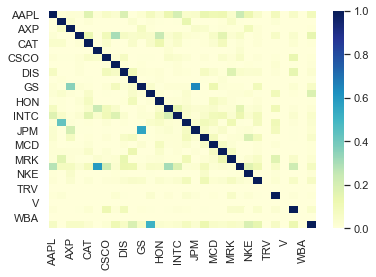

In [44]:
ax = sns.heatmap(news_correlation, cmap="YlGnBu")

# 4. Comparison with stock correlation and TBN

In [53]:
file_path = '../data/'
# load TBN tickers
file_name = 'gvkey_ticker.csv'
tickers_info = pd.read_csv(file_path + file_name,  header=0, usecols=[1, 2], index_col = [0], engine='c')
tickers_info = tickers_info.loc[~tickers_info.index.duplicated(keep='first')]

# load stock data
file_name = 'stock_data.csv'
stock_data = pd.read_csv(file_path + file_name,  header=0, index_col=[0], engine='c')
tickers_subset = stock_data.dropna(axis='columns').columns
tickers_key = tickers_info.loc[tickers_subset].gvkey.values

# load TBN data
file_path = '../data/'
file_type = 'TBN_*.csv'
file_list = glob.glob(file_path + file_type)

idx = pd.Index
tbn_combined = pd.DataFrame()
for file in file_list:
    year = int(file.split('/')[-1][4:8]) # not safe expression
    tbn = pd.read_csv(file,  header = 0, index_col = [0], engine='c')
    np.fill_diagonal(tbn.values, 0)
    row_num = tbn.shape[0]
    year_idx = idx(np.repeat(year, row_num))
    tbn.set_index(year_idx, append = True, inplace = True)
    tbn_combined = tbn_combined.append(tbn)
tbn_combined = tbn_combined.reorder_levels(order=[1,0])

In [54]:
# Na value
stock_data = stock_data.dropna(axis='columns') # drop incomplete data to form 26 columns

# set year as index 
date_format = '%Y-%m-%d' # Y for year, m for month, d for day
stock_date = pd.Index([datetime.strptime(x, date_format) for x in stock_data.index])
stock_data.index = [x.year for x in stock_date]

# calculate stock returns
stock_returns = stock_data.pct_change().dropna(axis='rows')

# correlation for stock return
correlation_aggregate = stock_returns.groupby(level=0).corr()
volatility_aggregate = stock_returns.groupby(level=0).std()
covariance_aggregate = stock_returns.groupby(level=0).cov()

In [55]:
correlation_return_2006 = correlation_aggregate.loc[2006]
correlation_text_2006 = tbn_combined.loc[2006]
correlation_text_2006.index = correlation_return_2006.index
correlation_text_2006.columns = correlation_return_2006.columns
np.fill_diagonal(correlation_return_2006.values, 0)
np.fill_diagonal(news_correlation.values, 0)

Text(0.5, 1.0, 'TBN Correlation')

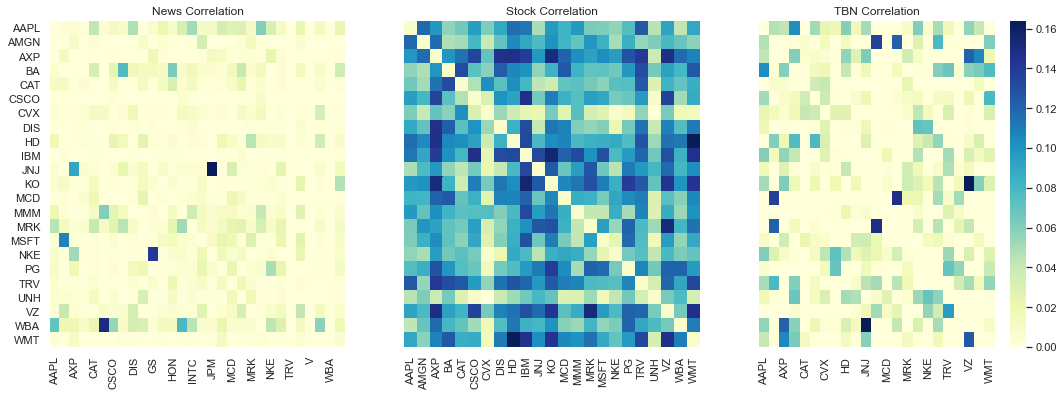

In [56]:
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True, figsize=(18, 6))

g1 = sns.heatmap(news_correlation,cmap="YlGnBu", cbar=False, ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title('News Correlation')

g2 = sns.heatmap(correlation_return_2006,cmap="YlGnBu",cbar=False,ax=ax2)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_title('Stock Correlation')

g3 = sns.heatmap(correlation_text_2006, cmap="YlGnBu",ax=ax3)
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_title('TBN Correlation')

In [ ]:
f.savefig('../picture/matrix_compare.pn')